In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt 
import scipy
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

sys.path.append(os.path.abspath('..'))
from xenium_cluster import XeniumCluster

In [2]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"../../../xenium/data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    clustering.xenium_spot_data.X = clustering.xenium_spot_data.X.A
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]
    clustering.xenium_spot_data.obs.rename(columns={"array_row": "row", "array_col": "col"}, inplace=True)

    return data, spatial_locations, clustering

In [3]:
# Data Properties
batch_size = 256
data_dimension = 5
num_clusters = 7
learn_global_variances = False

In [4]:
gene_data, spatial_locations, original_adata = prepare_DLPFC_data(151673)
prior_means = torch.zeros(num_clusters, gene_data.shape[1])
prior_scales = torch.ones(num_clusters, gene_data.shape[1])

In [5]:
original_adata.xenium_spot_data.var

,gene_ids,feature_types,genome,feature_name
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG
FAM138A,ENSG00000237613,Gene Expression,GRCh38,FAM138A
OR4F5,ENSG00000186092,Gene Expression,GRCh38,OR4F5
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,AL627309.1
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,AL627309.3
...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,AC233755.2
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,AC233755.1
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,AC240274.1
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,AC213203.1


/tmp/ipykernel_1473253/3209538980.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid[rows, columns] = torch.tensor(original_adata.xenium_spot_data.obs["Region"].cat.codes.values.astype(int)) + 1
/tmp/ipykernel_1473253/3209538980.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


Text(0.5, 1.0, 'Ground Truth Regions of DLPFC')

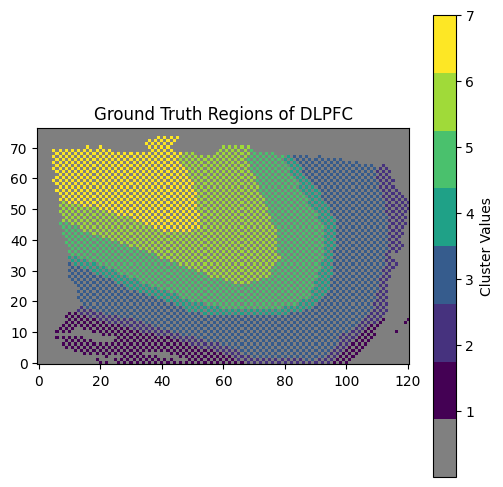

In [6]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(original_adata.xenium_spot_data.obs["Region"].cat.codes.values.astype(int)) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)
# Creating a medium gray color for the background
grey_color = [0.5, 0.5, 0.5, 1]  # RGB values for medium gray with full opacity
colormap_colors = np.vstack((grey_color, colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
plt.title('Ground Truth Regions of DLPFC')

In [7]:
original_adata.xenium_spot_data.obsm["X_pca"].std(axis=0)

array([12.4453335,  4.9366527,  2.0713081,  1.8259656,  1.5240269],
      dtype=float32)

/home/roko/diff/nf/xenium_cluster.py:370: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(data.obs["row"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:371: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(data.obs["col"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:372: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clusters = torch.tensor(data.obs["cluster"].astype(int))
/home/roko/diff/n

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

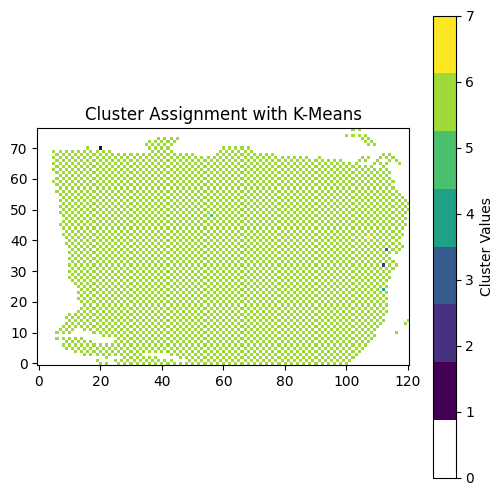

In [8]:
original_adata.KMeans(original_adata.xenium_spot_data, K=7, include_spatial=False)